# Fisher Information and Effective Dimension

This Jupyter notebook was created by [Umberto Borso](https://www.linkedin.com/in/umberto-borso-1990a11a1/) and is part of the Semester Project titled *"Quantum Advantage in Machine Learning: Investigating Entanglement and Quantum Feature Maps in Neural Networks"*. This nootebook contains part of the code used to analyze how the design choices of different Quantum feature maps and Variational Circuits affect the performance of a Quantum Neural Network in terms of Fisher Information and Effective Dimension. 

## Library Inclusions

**Important Observation**: For this project, we have incorporated a specialized version of the `qiskit_machine_learning` library, tailored specifically to align with the project requirements. The original version of this library is part of the Qiskit community and can be accessed [here](git@github.com:qiskit-community/qiskit-machine-learning.git). Our customized version, which has been altered for this particular project, is available [here](https://github.com/uborso/qiskit-machine-learning.git). This modified repository has been conveniently integrated into the current repository as a submodule.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes, ExcitationPreserving, PauliFeatureMap,EfficientSU2, PauliTwoDesign

import sys
sys.path.insert(0, "./external/qiskit-machine-learning/")
from qiskit_machine_learning.neural_networks import EffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN

## Setting up QNN parameters

In the following cells we setup the specific parameters used in the Monte Carlo sampling process for estimating the Fisher information matrix and the effective dimension of the QNNs, providing insights into their capacity and trainability.

- `n` (Dataset Sizes): An array ranging from 1,000 to 1,000,000, used to calculate the effective dimension of QNNs across various data volumes.

- `num_qubits` (Number of Qubits): Set to 4, indicating the size of the quantum circuits in the QNN models.

- `num_input_samples` (Number of Input Samples): Fixed at 100, this number defines how many sets of input data samples, drawn from a Gaussian distribution, are used in the analysis.

- `num_weight_samples` (Number of Weight Samples): Also 100, determining the number of parameter sample sets for exploring the QNN models' parameter space.

In [25]:
n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
num_qubits = 4

# we can set the total number of input samples and weight samples for random selection
num_input_samples = 100
num_weight_samples = 100


# Defining the QNN model

This code sets up a Quantum Neural Network (QNN) by specifying and combining various feature maps and variational circuits, followed by defining a post-processing function and creating the QNN model.

- **Define Feature Maps and Variational Circuits**: Two dictionaries, `feature_maps` and `variational_circuits`, are created. Each contains different types of quantum feature maps (like `PauliFeatureMap`) and variational circuits (like `PauliTwoDesign`, `ExcitationPreserving`, etc.), respectively, specified for a 4-qubit system.

- **Select Specific Feature Map and Variational Circuit**: The code selects a specific feature map (ex. `FM3`) and a variational circuit (ex. `VC1`) from these dictionaries for the analysis.

- **Construct Quantum Circuit**: A quantum circuit (`qc`) is created by appending the chosen feature map and variational circuit to it. This forms the core of the QNN.

- **Define Parity Function**: A parity function is defined to map bitstrings to 0 or 1. This function is used for post-processing the output of the QNN.

- **Construct QNN**: A `SamplerQNN` is constructed with the created quantum circuit, specifying input and weight parameters, the parity function for interpretation, and the output shape. The output shape is set to 2, corresponding to the number of classes in the parity mapping.

- **Effective Dimension Calculation**: The code then sets up an `EffectiveDimension` object (`global_ed`), using the QNN, number of weight samples, and number of input samples. This is used for analyzing the model's capacity.

In [ ]:
feature_maps = {
    'FM1': PauliFeatureMap(4, reps=1, paulis=['Z']),
    'FM2': PauliFeatureMap(4, reps=1, paulis=['ZZ']),
    'FM3': PauliFeatureMap(4, reps=1, paulis=['Z','ZZ']),
    'FM4': PauliFeatureMap(4, reps=1, paulis=['Z','XX']),
    'FM5': PauliFeatureMap(4, reps=1, paulis=['Y','ZX']),
    'FM6': PauliFeatureMap(4, reps=1, paulis=['Z','ZZZ']),
    'FM7': PauliFeatureMap(4, reps=1, paulis=['Z','YY','ZZZ']),
}

variational_circuits = {
    'VC1': PauliTwoDesign(num_qubits=4, reps=9, seed=None, insert_barriers=False, name='PauliTwoDesign'),
    'VC2': ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='circular',skip_final_rotation_layer=True),
    'VC3': ExcitationPreserving(4, reps=4, insert_barriers=True, entanglement='full'),
    'VC4': RealAmplitudes(4, reps=9, insert_barriers=True, entanglement='full'),
    'VC5': ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='pairwise',skip_final_rotation_layer=False),
    'VC6': ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='linear'),
    'VC7': EfficientSU2(4, su2_gates=['rx', 'y'], entanglement='circular', reps=9),
    'VC8': RealAmplitudes(4, reps=9, insert_barriers=True, entanglement='linear'),
    'VC9': ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='sca',skip_final_rotation_layer=True)
}

In [26]:
# choose a feature map
fm_label = 'FM3'
feature_map = feature_maps[fm_label]
# choose a variational circuit
vc_label = 'VC1'
ansatz = variational_circuits[vc_label]

qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))

# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
# construct QNN
qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
)


global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples
)

d = qnn.num_weights

40


# Evaluate Model Performance

Here we focus on evaluating a Quantum Neural Network (QNN) model. The key steps include:

- **Monte Carlo Sampling**: Executes `global_ed.run_monte_carlo()` to obtain the model's Jacobian matrix and outputs for various input and weight sample combinations. Note this step may require about ~20 mins on a standard laptop.

- **Compute Fisher Information**: Utilizes `global_ed.get_fisher_information()` to calculate Fisher information matrices from the gradients and outputs. Normalizes these matrices using `global_ed.get_normalized_fisher()`.

- **Calculate Effective Dimension**: Computes the model's effective dimension for different dataset sizes (`n`) through `global_ed._get_effective_dimension()`.

- **Save and Plot Results**: The calculated metrics (Fisher information, normalized Fisher information, and effective dimensions) are saved for further analysis. The code also plots the normalized effective dimension to visualize the model's scaling with dataset size.

In [ ]:
grads, output = global_ed.run_monte_carlo()

np.save("./NPY_files/" + vc_label + "_grads.npy", grads)
np.save("./NPY_files/" + vc_label +"_output.npy", output)

# uncomment these two lines to load previously calculated grads and outputs
# grads = np.load("./NPY_files/" + vc_label + "_grads.npy")
# output = np.load("./NPY_files/" + vc_label +"_output.npy")

# compute as many fisher info. matrices as (input, params) sets
fisher = global_ed.get_fisher_information(gradients=grads, model_outputs=output)

# get normalized fisher info matrices
normalized_fisher, _ = global_ed.get_normalized_fisher(fisher)

# compute eff. dim
effective_dimensions = global_ed._get_effective_dimension(normalized_fisher, n)

# save outputs to .npy file for later processing and plotting
fne = np.array([fisher,normalized_fisher,effective_dimensions])
np.save("./NPY_files/" + vc_label +"_fne.npy", fne)

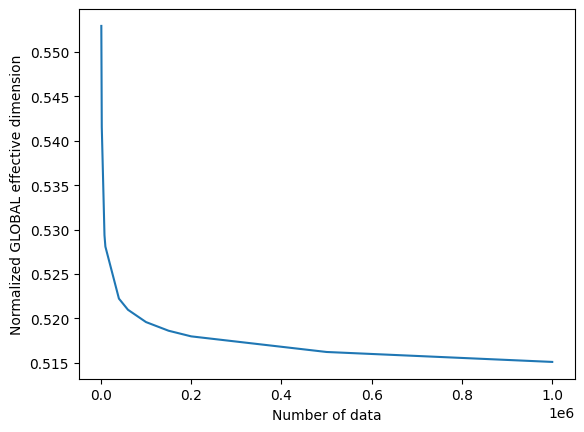

In [31]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(effective_dimensions) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()